In [4]:
import numpy as np
from scipy.stats import gamma
from scipy.fft import ifft
import sympy as sp 
import matplotlib.pyplot as plt
import pyfeng as pf
from fft import InvLap

In [2]:
# params: page 1688   
# T as 0.5 or 0.25

texp, v0, k, theta, epsilon = 0.5, 0.0348, 1.15, 0.0348, 0.39

In [3]:
class cbarheston():

    def __init__(self, texp, k=k, v0=v0, theta=theta) -> None:
        self.k, self.v0, self.theta, self.texp = k, v0, theta, texp

    def c0(self, n=50):
        eq1 = self.v0 / self.k * (1 - np.exp(-self.k * self.texp))
        eq2 = self.theta / self.k * (np.exp(-self.texp) - 1)
        eq3 = self.theta * self.texp
        return eq1 + eq2 + eq3
    
    def beta(self, sigma=1):
        return self.c0() * (np.exp(sigma ** 2 * self.texp) - 1)
    
    def alpha(self):
        return self.c0() / self.beta()
    
    def cbar(self, strike):
        alpha, beta = self.alpha(), self.beta()
        res = (
            alpha * beta * (1 - gamma.cdf(strike, alpha + 1, scale=beta))      # beta already inverted in the version given
            + strike * (1 - gamma.cdf(strike, alpha, scale=beta))        
        )
        return res
        

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyfeng/bsm.py:444: RuntimeWarning: invalid value encountered in log
  log_p_2pi = np.log(p) + MathConsts.M_LN2PI_2  # 0.5*np.log(2*np.pi)


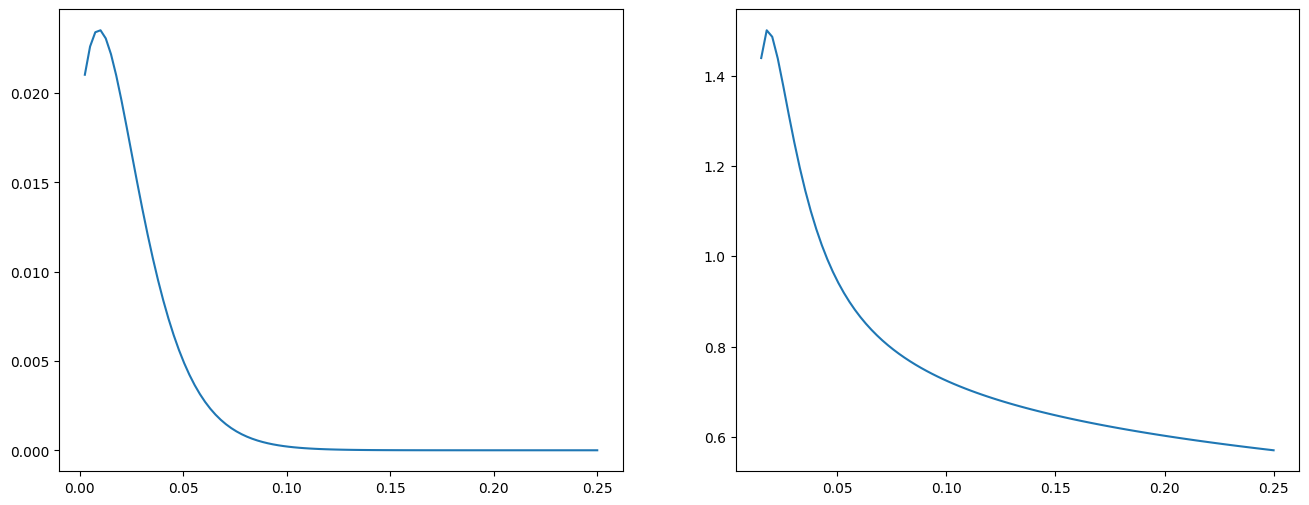

In [4]:
strike = np.linspace(0, 0.25, 100)[1:]
c = cbarheston(0.5)
p = np.array([])
for i in strike:
    p = np.r_[p, c.cbar(i)]

demovol = pf.Bsm(sigma=1)   # initialize a Bsm
impvol = demovol.impvol(p, strike, v0, 0.5)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(strike, p)
ax[1].plot(strike[5:], impvol[5:])

In [5]:
def gammacdf(t, alpha, beta):
    x = sp.symbols('x')
    return sp.integrate((1/(sp.gamma(alpha) * beta**alpha)) * x**(alpha - 1) * sp.exp(-x/beta), (x, 0, t))

class cbarhestonsp():

    def __init__(self, texp, k, v0, theta) -> None:
        self.k, self.v0, self.theta, self.texp = k, v0, theta, texp

    def c0(self):
        eq1 = self.v0 / self.k * (1 - sp.exp(-self.k * self.texp))
        eq2 = self.theta / self.k * (sp.exp(-self.texp) - 1)
        eq3 = self.theta * self.texp
        return eq1 + eq2 + eq3
    
    def beta(self, sigma=1):
        return self.c0() * (sp.exp(sigma ** 2 * self.texp) - 1)
    
    def alpha(self):
        return self.c0() / self.beta()

    def cbar(self, strike):
        alpha, beta = self.alpha(), self.beta()
        res = (
            alpha * beta * (1 - gammacdf(strike, alpha + 1, beta))      # could only accept single strike, array not allowed
            + strike * (1 - gammacdf(strike, alpha, beta))        
        )
        return res

In [20]:
class laplace(cbarhestonsp):

    def trans(self):
        strike, lbd = sp.symbols('k l')
        F, _, _ = sp.laplace_transform(self.cbar(strike), strike, lbd)
        return F

In [21]:
laplace(texp=texp, k=k, v0=v0, theta=theta).trans()

-1.12577655166044*LaplaceTransform(k*lowergamma(1.5414940825368, 82.3174773312411*k), k, l) - 0.0136760331846708*LaplaceTransform(lowergamma(2.5414940825368, 82.3174773312411*k), k, l) + 0.0187262065421892/l + l**(-2)

In [17]:
x = sp.symbols('x')
sp.lowergamma(3, x)

-2*(x**2/2 + x + 1)*exp(-x) + 2

In [8]:
def L_C0_heston(λ, k=k, θ=theta, ε=epsilon, T=texp, v0=v0):
    λ /= T
    γ = np.sqrt(k**2 + 2*λ*ε**2)
    b_0T = 2*λ*(np.exp(γ*T)-1)/((γ+k)*(np.exp(γ*T)-1) + 2*γ)
    α = γ + k
    β = γ - k

    a_0T = (k*θ/ε**2) * (k-γ)*T

    dt = 1e-3
    n_dt = int(T / dt)
    t = np.arange(0, T, dt)
    for k in range(n_dt-1):
        part1 = α*np.exp(γ*(T-t[k+1]))
        part2 = β*np.exp(-γ*dt)
        a_0T -= (2*k*θ/ε**2) * np.log((part1+part2) / (part1+β))

    L = np.exp(a_0T - b_0T*v0)
    return L

def L_heston(l):
    return (L_C0_heston(l) - 1)/l**2 + cbarheston(texp=texp).c0()/l

/var/folders/xg/zy9_x4zj4j52qbfj_k8_fk440000gn/T/ipykernel_70123/4271724804.py:3: RuntimeWarning: invalid value encountered in sqrt
  γ = np.sqrt(k**2 + 2*λ*ε**2)
/var/folders/xg/zy9_x4zj4j52qbfj_k8_fk440000gn/T/ipykernel_70123/4271724804.py:22: RuntimeWarning: invalid value encountered in divide
  return (L_C0_heston(l) - 1)/l**2 + cbarheston(texp=texp).c0()/l
/var/folders/xg/zy9_x4zj4j52qbfj_k8_fk440000gn/T/ipykernel_70123/4271724804.py:22: RuntimeWarning: divide by zero encountered in divide
  return (L_C0_heston(l) - 1)/l**2 + cbarheston(texp=texp).c0()/l


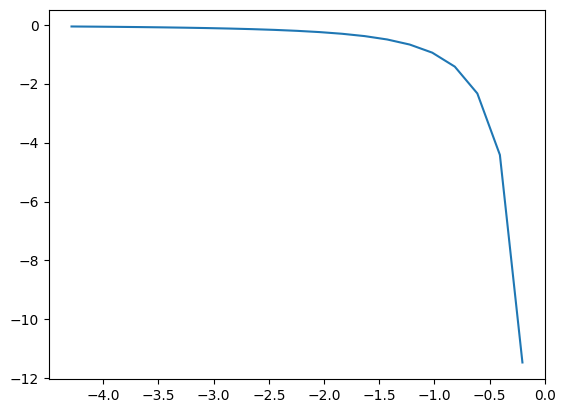

In [9]:
x = np.linspace(-5, 0, 50)
y = L_heston(x)
plt.plot(x, y)

In [10]:
InvLap(0.05, 100, -5000, 5000, L_heston)

1.1391785570030996e-36

In [5]:
ifft?

Signature:     
ifft(
    x,
    n=None,
    axis=-1,
    norm=None,
    overwrite_x=False,
    workers=None,
    *,
    plan=None,
)
Call signature: ifft(*args, **kwargs)
Type:           _Function
String form:    <uarray multimethod 'ifft'>
File:           /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/fft/_basic.py
Docstring:     
Compute the 1-D inverse discrete Fourier Transform.

This function computes the inverse of the 1-D *n*-point
discrete Fourier transform computed by `fft`.  In other words,
``ifft(fft(x)) == x`` to within numerical accuracy.

The input should be ordered in the same way as is returned by `fft`,
i.e.,

* ``x[0]`` should contain the zero frequency term,
* ``x[1:n//2]`` should contain the positive-frequency terms,
* ``x[n//2 + 1:]`` should contain the negative-frequency terms, in
  increasing order starting from the most negative frequency.

For an even number of input points, ``x[n//2]`` represents the sum of
the values at

In [7]:
rng = np.random.default_rng()
t = np.arange(400)
n = np.zeros((400,), dtype=complex)
n[40:60] = np.exp(1j*rng.uniform(0, 2*np.pi, (20,)))

In [10]:
n

array([ 0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,